# TEAM benchmark 7

https://www.compumag.org/wp/wp-content/uploads/2018/06/problem7.pdf

Solve Eddy-current problem
\begin{align*}
\nabla\times(\nu\nabla\times\mathbf{A}) + j\omega\sigma \mathbf{A} = \mathbf{J}
\end{align*}
with
\begin{align*}
\mathbf{A}\times\mathbf{n} = \mathbf{0}
\end{align*}
on the far boundary. The magnetic permability $\mu_0 = 4\pi \cdot 10^{-7}$ H/m of vaccuum, and the electric conductivity of the aluminium plate is $\sigma_{Al} = 35.26\cdot10^6$ S/m.

In [1]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
# from netgen.meshing import MeshingParameters

## Generate Geometry

### The aluminum plate:

In [2]:
wpplate = WorkPlane(Axes((0,0,0),Z,X))
f = wpplate.Rectangle(0.294,0.294).MoveTo(0.018,0.018).Rectangle(0.108,0.108).Reverse().Face()
plate = f.Extrude(0.019)

plate.edges.hpref=1    # mark edges for geometric refinement
plate.faces.hpref=1    # mark edges for geometric refinement

plate.faces.maxh=0.04
plate.solids.name="plate"
plate.faces.col=(0.3,0.3,0.3,1)
Draw (plate);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

### The coil:

In [3]:
wp = WorkPlane(Axes(p=(0.294,0.000,0.049), n=Z, h=Y)) # origin in 

coil2di = wp.MoveTo(0.100,0.100).RectangleC(0.100,0.100).Offset(0.025).Face()
coil2di.edges.name="coili"
coil2do = wp.MoveTo(0.100,0.100).RectangleC(0.100,0.100).Offset(0.050).Face()
coil2d = coil2do-coil2di

cutout = wp.MoveTo(0.100,0.100).RectangleC(0.300,0.100).Face() + \
         wp.MoveTo(0.100,0.100).RectangleC(0.100,0.300).Face()

coil2d = Glue( [coil2d*cutout, coil2d-cutout])

# Draw (coil2d)
coil = coil2d.Extrude(0.100)
coil.solids.name="coil"
Draw (coil);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [4]:
airbox = Box(Pnt(-.2, -.2, -.2), Pnt(0.5, 0.5, 0.5))
airbox.faces.name="outer"
airbox.solids.name="air"

airbox.faces.col = (0,0,1,0.3)

airbox = airbox-coil-plate
shape = Glue([ coil, plate, airbox])
Draw (shape);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [5]:
geo = OCCGeometry(shape)

In [6]:
xi_msm = np.array([0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270, 288]) * 1e-3
xi_sim = np.linspace(0,0.288,500)

In [7]:
mesh = Mesh(geo.GenerateMesh(maxh=0.2))
mesh.Curve(5)
mesh.RefineHP(levels=1, factor=0.2)
print("mats", set(mesh.GetMaterials()))
print("number of elements:", mesh.ne)

clipping_settings={"Clipping":{"enable":True, "z":-1, "dist":0}}
Draw(mesh, settings = clipping_settings);

mats {'coil', 'plate', 'air'}
number of elements: 19090


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Clipping': {'enable': True, …

## Coil currents

In [8]:
coilrect_xmin, coilrect_xmax = 0.294 - 0.150, 0.294-0.050
coilrect_ymin, coilrect_ymax = 0.050, 0.150

def Project(val, minval, maxval):
    return IfPos(val-minval, IfPos(val-maxval, maxval, val), minval)

projx = Project(x, coilrect_xmin, coilrect_xmax)
projy = Project(y, coilrect_ymin, coilrect_ymax)
tau_coil = CF( (projy-y, x-projx, 0) )
tau_coil /= Norm(tau_coil)
pot_coil = CF( (0, 0, sqrt((projy-y)**2+(projx-x)**2)-0.05) )

tau_coil_only = mesh.MaterialCF({"coil.*":tau_coil}, default=CF((0, 0, 0)))

In [9]:
clipping_settings={"Clipping":{"enable":True, "z":-1, "dist":-0.05}, "Objects":{"Clipping Plane":False, "Vectors":True}, "Vectors":{"grid_size":100}}
clipping_settings.update({"camera":{"transformations":[{"type":"move", "dir":(0,0,1), "dist":1.9}]}})
Draw(tau_coil_only, mesh,settings=clipping_settings, draw_surf=False); # top right, mesh, settings=clipping_settings)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Clipping': {'enable': True, …

## FEM

In [10]:
mu = 4*pi*1e-7
sigma = mesh.MaterialCF({"plate":35.26e6}, default=1)

In [11]:
turns = 2742

def Solve(f):
    omega = 2*pi*f
    fes = HCurl(mesh, order=3, complex=True, dirichlet="outer", gradientdomains="plate")
    print("free dofs", sum(fes.FreeDofs()))
    u, v = fes.TnT()
    
    a = BilinearForm(fes, symmetric=True, condense=True)
    a += 1/mu*curl(u)*curl(v)*dx
    a += 1j*omega*sigma * u*v*dx

    # volume current density
    # f = LinearForm(-turns/(0.025 * 0.100)*tau_coil*v * dx("coil.*", bonus_intorder=4))

    # boundary current density + div-free correction
    f = LinearForm(
            -turns/(0.100)*tau_coil*v.Trace() * ds("coili.*", bonus_intorder=4) \
            +turns/(0.025 * 0.100)*pot_coil*curl(v) * dx("coil.*", bonus_intorder=4))
    
    A = GridFunction(fes)
    pre = Preconditioner(a, type="bddc", inverse="sparsecholesky")
    # a.Assemble()
    # f.Assemble()
    # inv = solvers.CGSolver(mat=a.mat, pre=pre, printrates='\r', maxiter=200)
    # A.vec[:] = inv*f.vec
    solvers.BVP(bf=a, lf=f, gf=A, pre=pre, tol=1e-12, solver_flags={"printrates": "\r"})
    
    B = curl(A)
    J = -1j*omega*sigma * A
    return {"A":A, "B":B, "J":J}

with TaskManager():
    ret = Solve(f=200)
B, J = ret["B"], ret["J"]

free dofs 460691
CG iteration 1, residual = 1.8783429375726222     
CG iteration 2, residual = 0.8770371762416111     
CG iteration 3, residual = 0.8567761852506699     
CG iteration 4, residual = 0.8672534502660445     
CG iteration 5, residual = 0.6706888994529195     
CG iteration 6, residual = 0.541800899874667     
CG iteration 7, residual = 0.4786227798520621     
CG iteration 8, residual = 0.4922476312701087     
CG iteration 9, residual = 0.3355232375439637     
CG iteration 10, residual = 0.4094939964498205     
CG iteration 11, residual = 0.2834753118382017     
CG iteration 12, residual = 0.31796900540092854     
CG iteration 13, residual = 0.2472054289977912     
CG iteration 14, residual = 0.24330692037276122     
CG iteration 15, residual = 0.04739679249513447     
CG iteration 16, residual = 0.05498441491209653     
CG iteration 17, residual = 0.19009912530709314     
CG iteration 18, residual = 0.09507346786953996     
CG iteration 19, residual = 0.027171888380906974   

## Draw the B and J field

In [12]:
# clipping_settings={"Clipping":{"enable":True, "y":1, "z":0, "dist":0.1}, "Objects":{"Clipping Plane":False, "Vectors":True}, "Vectors":{"grid_size":100}}
# clipping_settings.update({"camera":{"transformations":[{"type":"rotateX", "angle":-90}, {"type":"move", "dir":(0,0,1.5), "dist":1}]}})
# Draw(B.real, mesh, settings=clipping_settings, max = 10e-3, min = 0, draw_surf=False);

clipping = { "function" : False,  "pnt" : (0,0.1,0), "vec" : (0,1,0) }
vectors = {"grid_size" : 50, "offset" : 0.5 }
Draw(B.real, mesh, clipping=clipping, vectors=vectors, max = 10e-3, min = 0, draw_surf=False);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [13]:
# clipping_settings={"Clipping":{"enable":True, "y":0, "z":-1, "dist":-0.132}, "Objects":{"Clipping Plane":False, "Vectors":True}, "Vectors":{"grid_size":150}}
# clipping_settings.update({"camera":{"transformations":[{"type":"move", "dir":(0,0,1), "dist":2.2}]}})
# Draw(mesh.MaterialCF({"plate":J.imag}, default = CF((0, 0, 0))), mesh, settings = clipping_settings, min = 0, max = 8e5);

clipping = { "function" : False,  "pnt" : (0,0,0.0189), "vec" : (0,0,-1) }
vectors = {"grid_size" : 100 }
Draw(mesh.MaterialCF({"plate":J.imag}, default = CF((0, 0, 0))), 
     mesh, clipping=clipping, vectors=vectors, min = 0, max = 8e5);


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

## Reference values of B and J from the bench-mark

In [14]:
Bz_A1B1_50Hz_ref = np.array([ -4.9  -1.16j, -17.88 +2.48j, -22.13 +4.15j, -20.19 +4.j,   -15.67 +3.07j,
   0.36 +2.31j,  43.64 +1.89j,  78.11 +4.97j,  71.55+12.61j , 60.44+14.15j,
  53.91+13.04j,  52.62+12.4j,  53.81+12.05j, 56.91+12.27j,  59.24+12.66j,
  52.78 +9.96j,  27.61 +2.26j])
               
Bz_A2B2_50Hz_ref = np.array([-1.83-1.63j, -8.5-0.6j, -13.6-0.43j, -15.21+0.11j, -14.48+1.26j, -5.62+3.4j,
 28.77+6.53j, 60.34+10.25j, 61.84+11.83j, 56.64+11.83j, 53.4+11.01j, 52.36+10.58j, 53.93+10.8j, 56.82+10.54j, 
 59.48+10.62j, 52.08+9.03j, 26.56+1.79j])

Jy_A3B3_50Hz_ref = np.array([0.249-0.629j,  0.685-0.873j,  0+0j,  0+0j,  0+0j,  0+0j,  0+0j,  -0.015-0.593j,
             -0.103-0.249j,  -0.061-0.101j,  -0.004-0.001j,  0.051+0.087j,  0.095+0.182j,  0.135+0.322j,  
             0.104+0.555j,  -0.321+0.822j,  -0.687+0.855j,])


Jy_A4B4_50Hz_ref = np.array([0.461-0.662j,  0.621-0.664j,  0+0j,  0+0j,  0+0j,  0+0j,  0+0j,  1.573-1.027j,
             0.556-0.757j,  0.237-0.364j,  0.097-0.149j,  -0.034+0.015j,  -0.157+0.154j,  -0.305+0.311j,
             -0.478+0.508j,  -0.66+0.747j,  -1.217+1.034j])


### Bz on A1 to B1

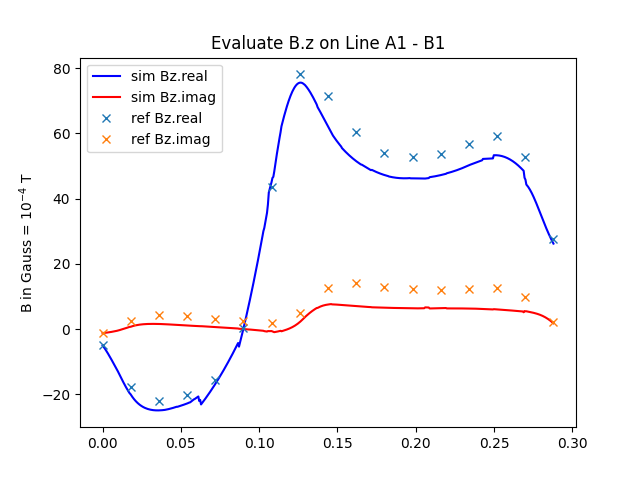

In [15]:
Bz_A1B1_sim = np.array([B[2](mesh(x, 0.072, 0.034)) for x in xi_sim])

plt.figure(1)
plt.clf()
plt.title("Evaluate B.z on Line A1 - B1")
plt.plot(xi_sim, -1e4*Bz_A1B1_sim.real, "b", label="sim Bz.real")
plt.plot(xi_sim, 1e4*Bz_A1B1_sim.imag, "r", label="sim Bz.imag")
plt.plot(xi_msm, Bz_A1B1_50Hz_ref.real, "x", label="ref Bz.real")
plt.plot(xi_msm, Bz_A1B1_50Hz_ref.imag, "x", label="ref Bz.imag")
plt.ylabel("B in Gauss = $10^{-4}$ T")
plt.legend()
plt.show()

### Bz on A2 to B2

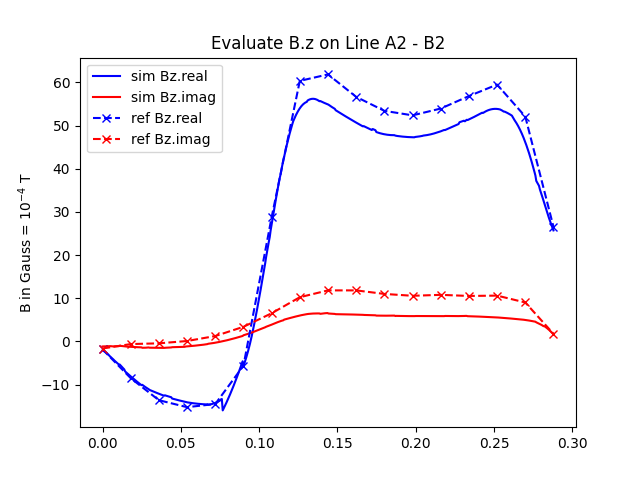

In [16]:
Bz_A2B2_sim = np.array([B[2](mesh(x, 0.144, 0.034)) for x in xi_sim])

plt.figure(2)
plt.clf()
plt.title("Evaluate B.z on Line A2 - B2")
plt.plot(xi_sim, -1e4 * Bz_A2B2_sim.real, "b", label="sim Bz.real")
plt.plot(xi_sim, 1e4 * Bz_A2B2_sim.imag, "r", label="sim Bz.imag")
plt.plot(xi_msm, Bz_A2B2_50Hz_ref.real, "b--x", label="ref Bz.real")
plt.plot(xi_msm, Bz_A2B2_50Hz_ref.imag, "r--x", label="ref Bz.imag")
plt.ylabel("B in Gauss = $10^{-4}$ T")
plt.legend()
plt.show()

In [17]:
clipping = { "function" : True,  "pnt" : (0,0.072,0), "vec" : (0,1,0) }

Draw (J[1].real, mesh, clipping = clipping, min=-0.5e6, max=0.5e6 )
Draw (J[1].imag, mesh, clipping = clipping, min=-0.5e6, max=0.5e6 );

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [18]:
Jy_A3B3_sim = np.array([1e-6*1j*J[1](mesh(x, 0.072, 0.019-1e-5)) for x in xi_sim])
Jy_A4B4_sim = np.array([1e-6*1j*J[1](mesh(x, 0.072, 0.000+1e-5)) for x in xi_sim])

## Jy on A3 to B3 - plate top:

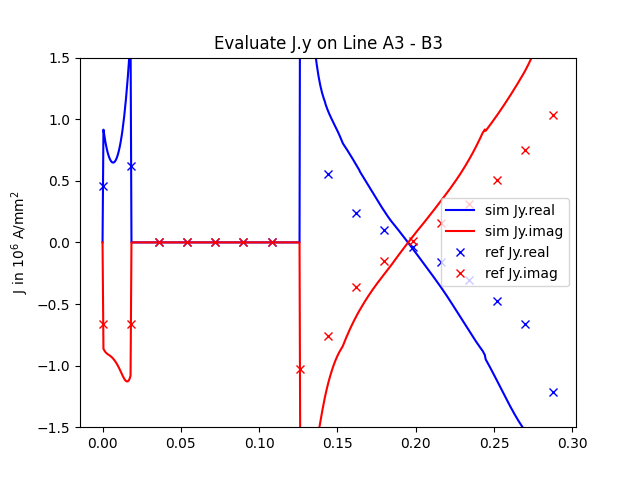

In [19]:
plt.figure(3)
plt.clf()
plt.title("Evaluate J.y on Line A3 - B3")
plt.plot(xi_sim, Jy_A3B3_sim.real, "b", label="sim Jy.real")
plt.plot(xi_sim, Jy_A3B3_sim.imag, "r", label="sim Jy.imag")
plt.plot(xi_msm, Jy_A4B4_50Hz_ref.real, "bx", label="ref Jy.real")
plt.plot(xi_msm, Jy_A4B4_50Hz_ref.imag, "rx", label="ref Jy.imag")
plt.ylabel("J in $10^{6}$ A/mm$^2$")
plt.ylim([-1.5,1.5])
plt.legend()
plt.show()

## Jy on A4 to B4  - plate bottom

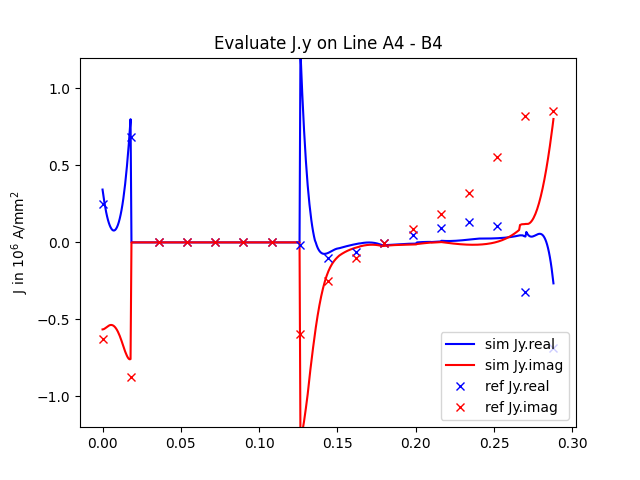

In [20]:
plt.figure(4)
plt.clf()
plt.title("Evaluate J.y on Line A4 - B4")
plt.plot(xi_sim, Jy_A4B4_sim.real, "b", label="sim Jy.real")
plt.plot(xi_sim, Jy_A4B4_sim.imag, "r", label="sim Jy.imag")
plt.plot(xi_msm, Jy_A3B3_50Hz_ref.real, "bx", label="ref Jy.real")
plt.plot(xi_msm, Jy_A3B3_50Hz_ref.imag, "rx", label="ref Jy.imag")
plt.ylabel("J in $10^{6}$ A/mm$^2$")
plt.ylim([-1.2,1.2])
plt.legend()
plt.show()